# Homework Module 3

#### Architecture - Semantic Search using Elastic Search


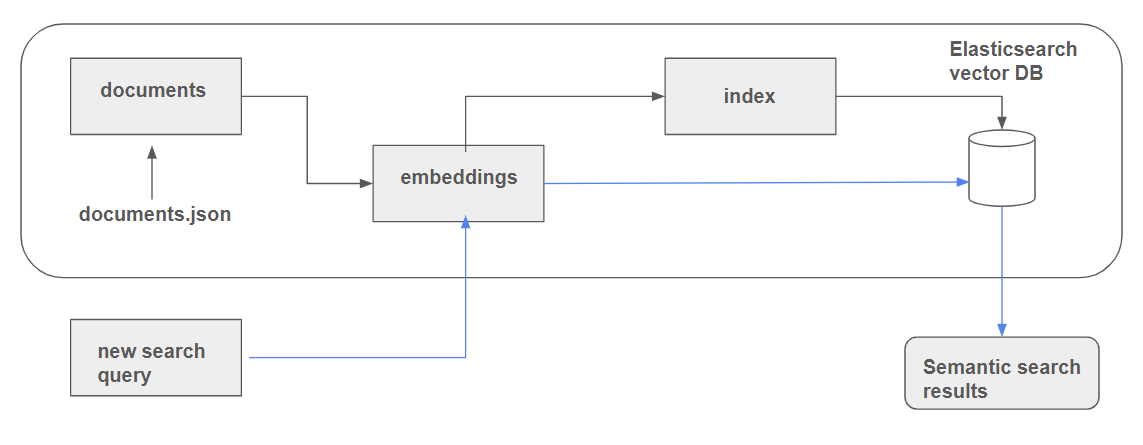

* Two very important concepts in Elasticsearch are documents and indexes.

* A document is collection of fields with their associated values. 

* To work with Elasticsearch you have to organize your data into documents, and then add all your documents to an index. 

* Index as a collection of documents that is stored in a highly optimized format designed to perform efficient searches.

## Q1. Getting the embeddings model

First, we will get the embeddings model `multi-qa-distilbert-cos-v1` from
[the Sentence Transformer library](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#model-overview)


#### Step 1: Create Embeddings using Pretrained Models

Sentence Transformers documentation here: https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

In [1]:
!pip install sentence_transformers==2.7.0


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# This is a new library compared to the previous modules. 
# Please perform "pip install sentence_transformers==2.7.0"
from sentence_transformers import SentenceTransformer

# if you get an error do the following:
# 1. Uninstall numpy 
# 2. Uninstall torch
# 3. pip install numpy==1.26.4
# 4. pip install torch
# run the above cell, it should work

/usr/local/python/3.10.13/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Get the model
model = SentenceTransformer("multi-qa-distilbert-cos-v1")

Create the embedding for this user question `I just discovered the course. Can I still join it?`. Enconde the text:

In [4]:
query_encoded = model.encode("I just discovered the course. Can I still join it?")
query_encoded

array([ 7.82226548e-02, -4.01311405e-02,  3.86135913e-02, -1.78966438e-04,
        8.92347097e-02, -5.04591092e-02, -1.05026569e-02,  3.71055678e-02,
       -4.18713912e-02,  3.48084792e-02, -1.20701883e-02, -2.36942340e-02,
        3.87900174e-02,  1.60988607e-02,  3.50747295e-02,  3.04746162e-03,
        5.79672381e-02, -4.10627462e-02, -3.41552682e-02, -2.56396383e-02,
       -3.55263911e-02,  1.42908087e-02, -1.62799917e-02,  3.21446545e-02,
       -4.66897376e-02,  7.89186060e-02,  4.90160920e-02,  1.56761166e-02,
       -1.69110075e-02,  2.26482227e-02,  5.60206100e-02, -3.98361087e-02,
        6.77409917e-02, -1.20209912e-02,  1.12621894e-03, -1.94394365e-02,
       -2.65951678e-02,  1.06177367e-02,  1.69687122e-02,  1.13487840e-02,
       -2.97063086e-02,  5.25258258e-02, -1.41453547e-02,  4.61699851e-02,
        1.17066065e-02, -2.38053519e-02, -6.32558241e-02, -1.92042235e-02,
       -7.10592186e-03,  3.24167833e-02,  2.49618199e-02, -5.27503015e-03,
        2.01149024e-02, -

What's the first value of the resulting vector?

* -0.24
* -0.04
* 0.07
* 0.27

In [8]:
7.8e-02

0.078

In [6]:
len(model.encode("This is a simple sentence"))

768

## Prepare the documents

Now we will create the embeddings for the documents.

Load the documents with ids that we prepared in the module.

#### Step 2: Prepare documents

In [5]:
import json
import requests 

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [6]:
print("Count documents: ",len(documents))

Count documents:  948


In [7]:
documents[0]

{'text': "The purpose of this document is to capture frequently asked technical questions\nThe exact day and hour of the course will be 15th Jan 2024 at 17h00. The course will start with the first  “Office Hours'' live.1\nSubscribe to course public Google Calendar (it works from Desktop only).\nRegister before the course starts using this link.\nJoin the course Telegram channel with announcements.\nDon’t forget to register in DataTalks.Club's Slack and join the channel.",
 'section': 'General course-related questions',
 'question': 'Course - When will the course start?',
 'course': 'data-engineering-zoomcamp',
 'id': 'c02e79ef'}

We will use only a subset of the questions - the questions
for `"machine-learning-zoomcamp"`. After filtering, you should
have only 375 documents


In [8]:
filtered_documents = [doc for doc in documents if doc['course']=="machine-learning-zoomcamp"]
print("Count of selected documents: ",len(filtered_documents))

Count of selected documents:  375


## Q2. Creating the embeddings

Now for each document, we will create an embedding for both question and answer fields.

We want to put all of them into a single matrix `X`:

- Create a list `embeddings` 
- Iterate over each document 
- `qa_text = f'{question} {text}'`
- compute the embedding for `qa_text`, append to `embeddings`
- At the end, let `X = np.array(embeddings)` (`import numpy as np`) 

In [9]:
import numpy as np

In [10]:
#created the dense vector using the pre-trained model
embeddings = []
for doc in filtered_documents:
    # Transforming the title into an embedding using the model
    qa_text = f"{doc['question']} {doc['text']}"
     #doc["text_vector"] = model.encode(doc["text"]).tolist()
    embeddings.append(model.encode(qa_text).tolist())

X = np.array(embeddings)
print("X shape: ",X.shape)

X shape:  (375, 768)


## Q3. Search

We have the embeddings and the query vector. Now let's compute the 
cosine similarity between the vector from Q1 (let's call it `v`) and the matrix from Q2. 

The vectors returned from the embedding model are already
normalized (you can check it by computing a dot product of a vector
with itself - it should return something very close to 1.0). This means that in order
to compute the coside similarity, it's sufficient to 
multiply the matrix `X` by the vector `v`:


```python
scores = X.dot(v)
```


In [11]:
scores= X.dot(query_encoded)
print("Highest score: ",np.max(scores))

Highest score:  0.6506573240979582



## Vector search

We can now compute the similarity between a query vector and all the embeddings.

Let's use this to implement our own vector search

In [12]:
class VectorSearchEngine():
    def __init__(self, documents, embeddings):
        self.documents = documents
        self.embeddings = embeddings

    def search(self, v_query, num_results=10):
        scores = self.embeddings.dot(v_query)
        idx = np.argsort(-scores)[:num_results]
        return [self.documents[i] for i in idx]

search_engine = VectorSearchEngine(documents=filtered_documents, embeddings=X)
top_docs = search_engine.search(query_encoded, num_results=5)
print(top_docs)

[{'text': 'Yes, you can. You won’t be able to submit some of the homeworks, but you can still take part in the course.\nIn order to get a certificate, you need to submit 2 out of 3 course projects and review 3 peers’ Projects by the deadline. It means that if you join the course at the end of November and manage to work on two projects, you will still be eligible for a certificate.', 'section': 'General course-related questions', 'question': 'The course has already started. Can I still join it?', 'course': 'machine-learning-zoomcamp', 'id': 'ee58a693'}, {'text': 'Welcome to the course! Go to the course page (http://mlzoomcamp.com/), scroll down and start going through the course materials. Then read everything in the cohort folder for your cohort’s year.\nClick on the links and start watching the videos. Also watch office hours from previous cohorts. Go to DTC youtube channel and click on Playlists and search for {course yyyy}. ML Zoomcamp was first launched in 2021.\nOr you can just u


## Q4. Hit-rate for our search engine

Let's evaluate the performance of our own search engine. We will
use the hitrate metric for evaluation.

First, load the ground truth dataset:

In [13]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [14]:
ground_truth

[{'question': 'Where can I sign up for the course?',
  'course': 'machine-learning-zoomcamp',
  'document': '0227b872'},
 {'question': 'Can you provide a link to sign up?',
  'course': 'machine-learning-zoomcamp',
  'document': '0227b872'},
 {'question': 'Is there an FAQ for this Machine Learning course?',
  'course': 'machine-learning-zoomcamp',
  'document': '0227b872'},
 {'question': 'Does this course have a GitHub repository for the sign-up link?',
  'course': 'machine-learning-zoomcamp',
  'document': '0227b872'},
 {'question': 'How can I structure my questions and answers for the course?',
  'course': 'machine-learning-zoomcamp',
  'document': '0227b872'},
 {'question': 'Are the course videos live or pre-recorded?',
  'course': 'machine-learning-zoomcamp',
  'document': '39fda9f0'},
 {'question': 'When can I start watching the course videos?',
  'course': 'machine-learning-zoomcamp',
  'document': '39fda9f0'},
 {'question': 'Are the live office hours sessions recorded?',
  'cours

Now use the code from the module to calculate the hitrate of
`VectorSearchEngine` with `num_results=5`.

What did you get?

In [15]:
print("Count of ground truth docs: ",len(ground_truth))


Count of ground truth docs:  1830


In [16]:
hitrate=[]
for gt_qa in ground_truth:
    query = model.encode(gt_qa['question'])
    top_docs = search_engine.search(query, num_results=5)
    hitrate+=[1 for doc in top_docs if doc['id']==gt_qa['document']]


In [17]:
print("Number of hits: ",len(hitrate))

Number of hits:  1725


In [18]:
print("Hitrate metric: ",len(hitrate)/len(ground_truth))

Hitrate metric:  0.9426229508196722


## Q5. Indexing with Elasticsearch

Now let's index these documents with elasticsearch

* Create the index with the same settings as in the module (but change the dimensions)
* Index the embeddings (note: you've already computed them)


#### Step 3: Setup ElasticSearch connection 

In [19]:
from elasticsearch import Elasticsearch
es_client = Elasticsearch('http://localhost:9200') 

es_client.info()

ObjectApiResponse({'name': '780f51d8d162', 'cluster_name': 'docker-cluster', 'cluster_uuid': '81ElHVnMRTmj3K3Bm7PFJg', 'version': {'number': '8.4.3', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '42f05b9372a9a4a470db3b52817899b99a76ee73', 'build_date': '2022-10-04T07:17:24.662462378Z', 'build_snapshot': False, 'lucene_version': '9.3.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

#### Step 4: Create Mappings and Index

* Mapping is the process of defining how a document, and the fields it contains, are stored and indexed.

* Each document is a collection of fields, which each have their own data type.

* We can compare mapping to a database schema in how it describes the fields and properties that documents hold, the datatype of each field (e.g., string, integer, or date), and how those fields should be indexed and stored 



In [39]:
index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "text"},
            "text_vector": {"type": "dense_vector", "dims": 768, "index": True, "similarity": "cosine"},
        }
    }
}

In [40]:
index_name = "ml-course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'ml-course-questions'})

### Step 4: Prepare the documents for index search

In [23]:
print("Count of documents: ",len(filtered_documents))
print("Example: \n",filtered_documents[0])

Count of documents:  375
Example: 
 {'text': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork', 'section': 'General course-related questions', 'question': 'How do I sign up?', 'course': 'machine-learning-zoomcamp', 'id': '0227b872'}


In [24]:
X.shape

(375, 768)

In [34]:
vectors = X[:,].tolist()
index_documents=[]
for doc,vector in zip(filtered_documents, vectors):
    doc['text_vector']=vector
    index_documents.append(doc)
print("Documents to index: ",len(index_documents))

Documents to index:  375


In [37]:
len(index_documents[0]['text_vector'])

768

In [41]:
index_documents[0]

{'text': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'section': 'General course-related questions',
 'question': 'How do I sign up?',
 'course': 'machine-learning-zoomcamp',
 'id': '0227b872',
 'text_vector': [0.08805905282497406,
  0.01559354830533266,
  0.07925581932067871,
  0.025275787338614464,
  0.07557650655508041,
  -0.03905969485640526,
  -0.041381385177373886,
  0.025291813537478447,
  0.02432412840425968,
  0.003625859972089529,
  -0.0072828554548323154,
  -0.03287515416741371,
  0.06129564717411995,
  -0.057110100984573364,
  0.011677478440105915,
  -0.01794421300292015,
  0.044920604676008224,
  -0.05416058748960495

#### Step 5: Add documents into index

In [42]:
for doc in index_documents:
    try:
        es_client.index(index=index_name, document=doc)
    except Exception as e:
        print(e)

#### Step 6: Create end user query

In [43]:
search_term = "I just discovered the course. Can I still join it?"
vector_search_term = model.encode(search_term)

In [44]:
query = {
    "field": "text_vector",
    "query_vector": vector_search_term,
    "k": 5,
    "num_candidates": 10000, 
}

In [46]:
res = es_client.search(index=index_name, knn=query, source=["text", "section", "question", "course","id"])
res["hits"]["hits"]

[{'_index': 'ml-course-questions',
  '_id': '30V5sJABN9O30PCkwXgQ',
  '_score': 0.82532895,
  '_source': {'question': 'The course has already started. Can I still join it?',
   'course': 'machine-learning-zoomcamp',
   'section': 'General course-related questions',
   'text': 'Yes, you can. You won’t be able to submit some of the homeworks, but you can still take part in the course.\nIn order to get a certificate, you need to submit 2 out of 3 course projects and review 3 peers’ Projects by the deadline. It means that if you join the course at the end of November and manage to work on two projects, you will still be eligible for a certificate.',
   'id': 'ee58a693'}},
 {'_index': 'ml-course-questions',
  '_id': '4kV5sJABN9O30PCkwXhi',
  '_score': 0.73585373,
  '_source': {'question': 'I just joined. What should I do next? How can I access course materials?',
   'course': 'machine-learning-zoomcamp',
   'section': 'General course-related questions',
   'text': 'Welcome to the course! Go

## Q6. Hit-rate for Elasticsearch

The search engine we used in Q4 computed the similarity between
the query and ALL the vectors in our database. Usually this is 
not practical, as we may have a lot of data.

Elasticsearch uses approximate techniques to make it faster. 

Let's evaluate how worse the results are when we switch from
exact search (as in Q4) to approximate search with Elastic.

What's hitrate for our dataset for Elastic?

In [58]:
hitrate=[]
for gt_qa in ground_truth:
    query = {
        "field": "text_vector",
        "query_vector": model.encode(gt_qa['question']),
        "k": 5,
        "num_candidates": 10000, 
    }
    res = es_client.search(index=index_name, knn=query, source=["text", "section", "question", "course","id"])
    hitrate+=[1 for doc in res["hits"]["hits"] if doc['_source']['id']==gt_qa['document']]


In [59]:
print("Hitrate metric: ",len(hitrate)/len(ground_truth))

Hitrate metric:  0.9426229508196722


1. https://logz.io/blog/elasticsearch-mapping/#:~:text=Within%20a%20search%20engine%2C%20mapping,indexes%20and%20stores%20its%20fields

2. https://www.sbert.net/docs/sentence_transformer/pretrained_models.html

3. https://www.elastic.co/search-labs/tutorials

4. https://www.elastic.co/search-labs/blog/text-similarity-search-with-vectors-in-elasticsearch